# Agenda do curso:
   - Classificação de imagens - Redes Neurais Convolucionais (CNNs)

   - Geração de  imagens - Redes Adversárias Generativas (GANs)

   - Segmentação de  objetos em imagens - U-net

# Importações de bibliotecas

In [ ]:
import os

import PIL.Image
import numpy as np

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import utils 

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [ ]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#print(gpu_devices)
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Variáveis globais

In [ ]:
normaisImages = []
comRiscoImages = []

normaisLabels = []
comRiscoLabels = []

trainLen = 0
testLen = 0

#base de treino, teste balanceado e desbalanceado
trainImages = []
trainLabels = []
testImagesB = []
testLabelsB = []


#labels, 0 -> normal, 1 -> comRisco
array_0 = 0
array_1 = 1

num_imgs = 48
img_rows = 600
img_cols = 600
channels = 3
num_classes = 2

In [ ]:
# load image from file
def select_image(filename):
    
    image = PIL.Image.open(filename)
    
    image = image.convert('RGB') #image.convert('L') #image.convert('RGB') 
    image = image.resize((img_rows, img_cols))
    
    #print(image.shape)
    
    img = np.array(image) 
    
    #print(img.shape)#(300, 300)
    img = img.reshape((1,) + img.shape)
    #print(img.shape)#(1, 300, 300)
    
    return img

In [ ]:
def scanning(PATH):
    contFiles = 0
    
    contents = os.listdir(PATH)
    for item in contents:
        newdir = PATH + "/" + item
        #print (newdir)
        if os.path.isdir(newdir):
            scanning(newdir)
        else:
            if item.endswith(".png") or item.endswith(".jpg") or item.endswith(".jpeg"):
                contFiles = contFiles + 1
                #print("cont: ", contFiles)
                if("Normal" in newdir and contFiles <= num_imgs):
                    normaisImages.append(select_image(newdir))
                    normaisLabels.append(array_0)
                elif("comRisco" in newdir and contFiles <= num_imgs):
                    comRiscoImages.append(select_image(newdir))
                    comRiscoLabels.append(array_1)
                    
    #print("cont: ", contFiles)

# Carregando as duas classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pathBase = "drive/MyDrive/Prj_Integrador_Univesp/PI_sem1_2022/SemRisco"
scanning(pathBase)

pathBase = "drive/MyDrive/Prj_Integrador_Univesp/PI_sem1_2022/ComRisco"
scanning(pathBase)

# Pré-processamento

In [ ]:
normaisImages = np.vstack(normaisImages)
normaisLabels = np.hstack(normaisLabels)
print(normaisImages.shape)
print(normaisLabels.shape)

(180000, 600, 3)
(300,)


In [ ]:
normaisImages = np.vstack(normaisImages)

In [ ]:
comRiscoImages = np.vstack(comRiscoImages)
comRiscoLabels = np.hstack(comRiscoLabels)
print(comRiscoImages.shape)
print(comRiscoLabels.shape)

(300, 600, 600, 3)
(300,)


In [ ]:
normaisLen = len(normaisImages)
print(normaisLen)
comRiscoLen = len(comRiscoImages)
print(comRiscoLen)

percentagemTrain = 0.80


if (normaisLen <= comRiscoLen):
    trainLen = percentagemTrain * normaisLen
    testLenB = normaisLen
    
elif (comRiscoLen < normaisLen):
    trainLen = percentagemTrain * comRiscoLen
    testLenB = comRiscoLen
    
print(int(trainLen))
print(int(testLenB))

300
300
240
300


In [ ]:
for i in range(int(trainLen)):
    trainImages.append(normaisImages[i])
    trainLabels.append(normaisLabels[i])
    trainImages.append(comRiscoImages[i])
    trainLabels.append(comRiscoLabels[i])

In [ ]:
trainImages = np.array(trainImages) 
trainImages = trainImages.astype('float32')
trainImages = trainImages / 255.0
print(trainImages.shape)

trainLabels = np.array(trainLabels)
print(trainLabels.shape)

(480, 600, 600, 3)
(480,)


# Base de teste balanceada

In [ ]:
for i in range(int(trainLen), int(testLenB)):
    testImagesB.append(normaisImages[i])
    testLabelsB.append(normaisLabels[i])
    testImagesB.append(comRiscoImages[i])
    testLabelsB.append(comRiscoLabels[i])

print(testLenB)
print(len(testImagesB))
print(len(testLabelsB))

300
120
120


In [ ]:
testImagesB = np.array(testImagesB) 
testImagesB = testImagesB.astype('float32')
testImagesB = testImagesB / 255.0
print(testImagesB.shape)

testLabelsB = np.array(testLabelsB)
print(testLabelsB.shape)

(120, 600, 600, 3)
(120,)


In [ ]:
if K.image_data_format() == 'channels_first':
    trainImages = trainImages.reshape(trainImages.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    trainImages = trainImages.reshape(trainImages.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)
    
print(trainImages.shape)
print(input_shape)

(480, 600, 600, 3)
(600, 600, 3)


In [ ]:
trainImages = shuffle(trainImages, random_state=19)
trainLabels = shuffle(trainLabels, random_state=19)

testImagesB = shuffle(testImagesB, random_state=19)
testLabelsB = shuffle(testLabelsB, random_state=19)

In [ ]:
trainLabels = utils.to_categorical(trainLabels, num_classes)
testLabelsB = utils.to_categorical(testLabelsB, num_classes)

print(trainLabels.shape)
print(testLabelsB.shape)

(480, 2)
(120, 2)


# Definindo hiperparâmetros

In [ ]:
batch_size_c   = 36
epoch        = 50

# Criando o modelo da CNN

In [ ]:
model = models.Sequential()

model.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

#model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(num_classes, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 598, 598, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 299, 299, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 297, 297, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1401856)           0         
_________________________________________________________________
dense (Dense)                (None, 256)               358875392 
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 5

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


https://keras.io/api/optimizers/

https://keras.io/api/losses/

https://keras.io/api/metrics/

In [ ]:
history = model.fit(trainImages, trainLabels,
                    batch_size = batch_size_c, 
                    epochs=epoch,
                    validation_split=0.1,
                    verbose = 1)

Epoch 1/50
12/12 [==============================] - 5s 403ms/step - loss: 4.5835 - accuracy: 0.7060 - val_loss: 0.1535 - val_accuracy: 0.9583
Epoch 2/50
12/12 [==============================] - 5s 428ms/step - loss: 0.1127 - accuracy: 0.9676 - val_loss: 0.0875 - val_accuracy: 0.9375
Epoch 3/50
12/12 [==============================] - 5s 444ms/step - loss: 0.0399 - accuracy: 0.9907 - val_loss: 0.0408 - val_accuracy: 0.9792
Epoch 4/50
12/12 [==============================] - 5s 450ms/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.0563 - val_accuracy: 0.9792
Epoch 5/50
12/12 [==============================] - 5s 446ms/step - loss: 0.0208 - accuracy: 0.9977 - val_loss: 0.0489 - val_accuracy: 0.9792
Epoch 6/50
12/12 [==============================] - 5s 433ms/step - loss: 0.0210 - accuracy: 0.9954 - val_loss: 0.0671 - val_accuracy: 0.9792
Epoch 7/50
12/12 [==============================] - 5s 450ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0550 - val_accuracy: 0.9792
Epoch 

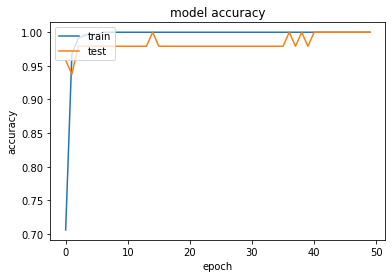

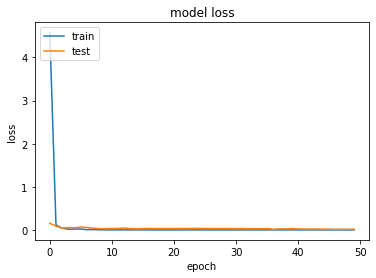

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Resultados

In [ ]:
lossValB, accValB = model.evaluate(testImagesB, testLabelsB)

print("LossB: ", lossValB)
print("AcuráciaB: ", accValB)

4/4 [==============================] - 1s 150ms/step - loss: 0.3021 - accuracy: 0.9667
LossB:  0.30210116505622864
AcuráciaB:  0.9666666388511658


In [ ]:
pred = model.predict(testImagesB)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testLabelsB,axis = 1)

In [ ]:
cm = confusion_matrix(y_true, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5), class_names = ['Normais', 'comRisco'])
plt.show()